# The effect of attending generalist schools on PISA test scores

### An analysis based on the PISA 2018 test 

In [142]:
#Data cleaning
import pandas as pd
import os
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier 
from statsmodels.stats.weightstats import DescrStatsW

import shap
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split



# 0) Functions

In [143]:
import pandas as pd 

def PerfectPredictors(df, grouping, treatment, controls):
    '''
    This function takes as input a dataframe a variable used to define subgroups within the dataset,
    a binary treatment variable and a list of controls and prints for eac variable in control if 
    the variable is a perfect prediictior in some of the subgroups
    '''
    # Create a set to include perfect predictors
    perfect_predictors = set()
    groups = set()
    for var in (controls.columns).tolist():
        #loop over potential control variables and add to the set the perfect predictors  

            for group in df[grouping].unique():
                df_group = df[df[grouping] == group]   # Loop over each group
           
                if df_group[df_group[treatment] == 1][var].nunique(dropna=True) == 1:
                        perfect_predictors.add(var)
                        groups.add(group)
                        print(f'{var} in {group} is a perfect predictor of treatment')
                if df_group[df_group[treatment] == 0][var].nunique(dropna=True) == 1:
                        perfect_predictors.add(var)
                        groups.add(group)
                        print(f'{var} in {group} is a perfect predictor of control')

    return perfect_predictors, groups

In [144]:
import pandas as pd

def CorrelationTreshold(df, threshold):
    """
    Given an dataset and a treshold this function
    returns a list of variables from the dataframe that have a correlation
    coefficient greater than the specified threshold.
    """
    # Calculate the correlation matrix
    corr = df.corr()

    # Filter variables based on correlation
    varlist = set()
    for col in corr.columns:
        correlated_vars = corr[corr[col] > threshold].index
        # Exclude correlations with the same variable
        correlated_vars = correlated_vars.difference([col])
        varlist.update(correlated_vars)

    varlist = list(varlist)
    return varlist

In [145]:
import pandas as pd
from itertools import combinations

def MissingEvaluate(df, threshold=0):
    """
    This function take as input one dataset and a given treshold and prints for each variable in the dataset
    the respective number of:
    - missing values
    - unique missing values (i.e. missing values only in that variable and not in the others)
    - the combinations of variables with missing observations in common  
    """
    # Initialize dictionaries to store results
    missing_counts = {}
    unique_missing_counts = {}
    common_missing_counts = {}
    combination_counts = {}

    # Standard missing for each variable
    var_list = df.columns
    for var in var_list:
        missing_counts[var] = df[var].isnull().sum()

    # unique missing for each variable
    for var in var_list:
        unique_missing_counts[var] = sum(1 for row in df.itertuples() if pd.isnull(getattr(row, var)) and sum(pd.isnull(getattr(row, v)) for v in var_list) == 1)

    # Common missing value combinations
    for row in df.itertuples():
        missing_vars = [var for var in var_list if pd.isnull(getattr(row, var))]
        if len(missing_vars) > 1:
            missing_vars_tuple = tuple(sorted(missing_vars))
            if missing_vars_tuple in combination_counts:
                combination_counts[missing_vars_tuple] += 1
            else:
                combination_counts[missing_vars_tuple] = 1

    # Results
    print('''
    MISSING VALS AND UNIQUE MISSING
    ''')
    for var in var_list:
        if unique_missing_counts[var] >= threshold:
            print(f"{var} has {missing_counts[var]} missing values and {unique_missing_counts[var]} unique missing values")
    
    print('''
    COMMON MISSING
    ''')
    for combo, count in combination_counts.items():
        if count >= threshold:
            print(f"{' '.join(combo)} have {count} observation(s) with common missing values")

In [146]:
#set random state to use trought all the project  
state=46  

# 1) Data Cleaning

In this first section I will prepare the dataset for the analysis, this entails

### 1.1) Generate the treatment variable

#### 1.1.1) Merge the two PISA 2018 dataset

Every round of PISA is composed of two dataset containing the information of students & their parents (this latter only for some students) and their schools. Those file can be merged together based on student and school ID. 

The dataset in .dta STATA format are available at https://drive.google.com/file/d/1KJIz9ad1oiiKbTfr29QFiGTTm_obcl_X/view?usp=sharing thanks to the conversion made from 'EVIDENCE INSTITUTE'

Given that for my analysis I will have to keep only a specific sumbet of countries, namely countries that:
- are European (meaning they are included in the 2018 Eurydice's 'The Structure of the European Education Systems 2018/19: Schematic Diagrams', available here: https://eurydice.eacea.ec.europa.eu/publications/structure-european-education-systems-201819-schematic-diagrams)
- divide students into different tracks before age 15
- divides students into different tracks without any admission test

Moreover, as I will use only a fraction of the variables present in the datasets, after loading each individual dataset I will keep only observations from those countries to reduce the computational burden associated to the merging operation
 

In [147]:
#Loading, shrinking and sorting datasets to merge them 

if not os.path.isfile('PISA 2018.csv'):
    #Select Countries
    Countries = ['ALB', 'BEL', 'BGR', 'BIH', 'CHE', 'CYP', 'CZE', 
                 'FRA', 'GRC', 'HRV', 'HUN', 'ITA', 'LIE', 'LTU', 'LUX', 
                 'MKD', 'MNE', 'PRT', 'ROU', 'SRB', 'SVK', 'SVN', 'TUR']
    #Select variables 
    weights = ['w_fstuwt', 'w_fsturwt12', 'w_fsturwt24', 'w_fsturwt36', 'w_fsturwt48', 
            'w_fsturwt60', 'w_fsturwt72', 'w_fsturwt1', 'w_fsturwt13', 'w_fsturwt25', 
            'w_fsturwt37', 'w_fsturwt49', 'w_fsturwt61', 'w_fsturwt73', 'w_fsturwt2', 
            'w_fsturwt14', 'w_fsturwt26', 'w_fsturwt38', 'w_fsturwt50', 'w_fsturwt62', 
            'w_fsturwt74', 'w_fsturwt3', 'w_fsturwt15', 'w_fsturwt27', 'w_fsturwt39', 
            'w_fsturwt51', 'w_fsturwt63', 'w_fsturwt75', 'w_fsturwt4', 'w_fsturwt16', 
            'w_fsturwt28', 'w_fsturwt40', 'w_fsturwt52', 'w_fsturwt64', 'w_fsturwt76', 
            'w_fsturwt5', 'w_fsturwt17', 'w_fsturwt29', 'w_fsturwt41', 'w_fsturwt53', 
            'w_fsturwt65', 'w_fsturwt77', 'w_fsturwt6', 'w_fsturwt18', 'w_fsturwt30', 
            'w_fsturwt42', 'w_fsturwt54', 'w_fsturwt66', 'w_fsturwt78', 'w_fsturwt7', 
            'w_fsturwt19', 'w_fsturwt31', 'w_fsturwt43', 'w_fsturwt55', 'w_fsturwt67', 
            'w_fsturwt79', 'w_fsturwt8', 'w_fsturwt20', 'w_fsturwt32', 'w_fsturwt44', 
            'w_fsturwt56', 'w_fsturwt68', 'w_fsturwt80', 'w_fsturwt9', 'w_fsturwt21', 
            'w_fsturwt33', 'w_fsturwt45', 'w_fsturwt57', 'w_fsturwt69', 'w_fsturwt10', 
            'w_fsturwt22', 'w_fsturwt34', 'w_fsturwt46', 'w_fsturwt58', 'w_fsturwt70', 
            'w_fsturwt11', 'w_fsturwt23', 'w_fsturwt35', 'w_fsturwt47', 'w_fsturwt59', 
            'w_fsturwt71']  
    
    pvs = ['pv1math', 'pv3math', 'pv5math', 'pv7math', 'pv9math', 
            'pv1scie', 'pv3scie', 'pv5scie', 'pv7scie', 'pv9scie', 
            'pv1read', 'pv3read', 'pv5read', 'pv7read', 
            'pv9read', 'pv2math', 'pv4math', 'pv6math', 'pv8math', 
            'pv10math', 'pv2scie', 'pv4scie', 'pv6scie', 'pv8scie', 
            'pv10scie', 'pv2read', 'pv4read', 'pv6read', 
            'pv8read', 'pv10read']
    
    stud_vars = ['cnt', 'cntschid', 'cntstuid', 'cntryid', 'progn',
                 'pa041q01ta', 'pa042q01ta', 'bmmj1', 'bfmj2', 'hisei', 
                 'fisced', 'misced', 'hisced', 'pqschool', 'pa003q02ta', 
                 'pa003q03ta', 'pa005q01ta', 'pa006q01ta', 'pa006q02ta', 
                 'pa006q03ta', 'pa006q04ta', 'pa006q05ta', 'pa006q06ta', 
                 'pa006q07ta', 'pa006q08ta', 'pa006q09ta', 'pa006q10ta', 
                 'pa006q11ta', 'durecec', 'cursupp', 'emosupp', 
                 'oecd', 'st126q01ta', 'repeat', 'scchange', 'immig', 
                 'lmins', 'mmins', 'smins', 'progn', 'cultposs', 'entuse', 
                 'escs', 'hedres', 'homepos', 'homesch', 'icthome', 'ictres', 
                 'ictsch', 'wealth', 'st125q01na', 'st004d01t'] + weights + pvs  
    sc_vars = ['cnt', 'cntschid', 'sc012q01ta', 'proatce', 'proat5ab', 'proat5am', 'proat6', 
               'schsize', 'schltype', 'stratio', 'sc052q01na', 'sc052q02na', 
               'sc052q03ha', 'sc048q01na', 'sc048q02na', 'sc048q03na', 'clsize']
    #ensure no duplicates are present by:
    stud_vars = list(set(stud_vars))
    sc_vars = list(set(sc_vars))

    
    #Import and merge datasets
    df_sc = pd.read_stata("PISA 2018 SC.dta", convert_categoricals=False, preserve_dtypes=False, columns=sc_vars)
    df_sc = df_sc[df_sc['cnt'].isin(Countries)]
    df_sc = df_sc.sort_values(by=['cnt', 'cntschid'])    
    
    df_st = pd.read_stata("PISA 2018 ST.dta",convert_categoricals=False, preserve_dtypes=False, columns=stud_vars) 
    df_st = df_st[df_st['cnt'].isin(Countries)]
    df_st = df_st.sort_values(by=['cnt', 'cntschid', 'cntstuid'])

    df_merged = pd.merge(df_st, df_sc, on=['cnt', 'cntschid'], how='outer') # obtain the final merged dataset 
    #Rename variables
    df_merged.rename(columns={'pa041q01ta': 'cost_pa', 'pa042q01ta': 'income_pa','pqschool': 'quality_pa',
                       'pa003q02ta': 'meal_pa', 'pa003q03ta': 'talking_pa', 'pa005q01ta': 'ch_options',
                       'pa006q01ta': 'ch_distance','pa006q02ta': 'ch_reputation', 'pa006q03ta': 'ch_courses',
                       'pa006q04ta': 'ch_philosopy', 'pa006q05ta': 'ch_teaching', 'pa006q06ta': 'ch_siblings',
                       'pa006q07ta': 'ch_lowcost', 'pa006q08ta': 'ch_financialaid', 
                       'pa006q09ta': 'ch_positiveenviroment', 'pa006q10ta': 'ch_academics',
                       'pa006q11ta': 'ch_safety', 'cursupp': 'cursupp_pa', 'emosupp': 'emosupp_pa',
                       'st003d02t': 'month_birth','st003d03t': 'year_birth','st004d01t': 'male',
                       'st126q01ta': 'age_elementary','st022q01ta': 'diff_lang','sc012q01ta': 'admission_records',
                       'sc052q01na': 'schelp_library', 'sc052q02na': 'schelp_staff','sc052q03ha': 'schelp_peer',
                       'sc048q01na': 'prop_difflang','sc048q02na': 'prop_special', 'sc048q03na': 'prop_disadv'},
              inplace=True)
    
    df_merged.to_csv("PISA 2018.csv")

else:
    print("Dataset 'PISA 2018.csv' already present")


Dataset 'PISA 2018.csv' already present


#### 1.1.2) Extact school codes
I will load a CSV file obrained by extracting the values of the variable "PROGN" that represents the national nname of the program from the official PISA 2018 codebook available at: https://webfs.oecd.org/pisa2018/PISA2018_CODEBOOK.xlsx  

The purpose of this code is to extract the numbers associated to technical or vocational progammes and the ones associated to licea, removing all the others in which I am not interested in (such as missing values, individuals in secondary school etc). Using this codes I will be able to generate my binary treatment variable 'g', taking value one for individuals enrolled in generalist schools and value 0 for those enrolled in technical/vocational programmes.   

In [148]:
# Load the CSV file containing program names and codes
df_codes = pd.read_csv('2018 code extraction.csv',sep=';', dtype={'Data':str})

# Generate lists containing the words to look for in order to select the relevant codes
missing = ['middle','isced2','lower', 'missing', 'primary', 'basic', 'part-time', 'elemetary', 'compulsory', 'basic', 'remedial', 'tertiary', 'adults', 'senior', 'help', 'post secondary', 'other', 'Conservatory', 'ballet']
vocational = ['Vovactional','isced 3b','isced 3c','voc', 'professional', 'practical','tech', 'VET', 'TVET', 'sectoral', 'agricultural', 'applied', 'specialised', 'specialized'] ##generalist = ['general', 'academic', 'lyce', 'Upper Gymnasium' ]
#added after check
missing = missing + ['Pre-vocational', 'Art programmes', 'Second & third stage artistic secondary education', 'Junior', 'Arts Upper Secondary', 'Art school', 'Preparatory course for vocational education', 'Secondary Education - Artistic', 'Waldorf','special Secondary', 'Second year of first stage', 'Grades 7 - 9', 'Austria: Special eduction school', 'Lithuania: Progymnasium', 'introduction programmes', 'admission to ISCED 3', 'preparing for VMBO']
vocational = vocational + ['without a school leaving examination']

# Join the words using the "or" connector
miss = '|'.join(missing)
voc = '|'.join(vocational)

print(f'''The keywords used to higlight missing values and non full-time upper secondary schoool programs are:
    {miss}''')
print(f'''The keywords used to higlight technical and professional training school programs are: 
    {voc}''')

# By means of str.contains() create two "masks" which select the programs containing the abovementioned keywords
maskmiss = df_codes['Program'].str.contains(miss, case=False, na=False)
maskvoc = df_codes['Program'].str.contains(voc, case=False, na=False)

# Keep only full-time upper seconday programmes
df_codes = df_codes[~maskmiss]

#generate two lists containing the values of generalist and non generalist programmes
generalist = df_codes.loc[~maskvoc, 'Data'].tolist()
generalist = list(map(int, generalist))
vocational = df_codes.loc[maskvoc, 'Data'].tolist()
vocational = list(map(int, vocational))

print(f'''
Codes for generalist schools: {generalist}

Codes for vocational schools: {vocational}''')

The keywords used to higlight missing values and non full-time upper secondary schoool programs are:
    middle|isced2|lower|missing|primary|basic|part-time|elemetary|compulsory|basic|remedial|tertiary|adults|senior|help|post secondary|other|Conservatory|ballet|Pre-vocational|Art programmes|Second & third stage artistic secondary education|Junior|Arts Upper Secondary|Art school|Preparatory course for vocational education|Secondary Education - Artistic|Waldorf|special Secondary|Second year of first stage|Grades 7 - 9|Austria: Special eduction school|Lithuania: Progymnasium|introduction programmes|admission to ISCED 3|preparing for VMBO
The keywords used to higlight technical and professional training school programs are: 
    Vovactional|isced 3b|isced 3c|voc|professional|practical|tech|VET|TVET|sectoral|agricultural|applied|specialised|specialized|without a school leaving examination

Codes for generalist schools: [80002, 310002, 320003, 320007, 360003, 400008, 400010, 560001, 560005, 

In [149]:
df_codes['Data'] = pd.to_numeric(df_codes['Data'], errors='coerce')

In [150]:
#Check for errors/misclassifications
for code in generalist:
    print(f'{code}, {df_codes.loc[df_codes["Data"] == code, "Program"].values}')

#After the chek I added the following to the previous lists 
#missing: 'special Secondary' 'Second year of first stage', 'Grades 7 - 9', 'Austria: Special eduction school', 'Lithuania: Progymnasium', 'introduction programmes', 'admission to ISCED 3', 'preparing for VMBO',
#vocational: 'without a school leaving examination'

80002, ['Albania: Upper secondary education']
310002, ['Baku (Azerbaijan) : Upper secondary education']
320003, ['Argentina: General Programme - Upper  Secondary  (4th, 5th and  6th year)']
320007, ['Argentina: General Programme - Upper  Secondary  (3th, 4th and 5th year)']
360003, ['Australia: Upper secondary general academic']
400008, ['Austria: Academic secondary school upper level']
400010, ['Austria: Upper Secondary school']
560001, ['Belgium: (First year A of first stage of) secondary Education']
560005, ['Belgium: Second & third stage general secondary education']
560012, ['Belgium: 1st or 2d year of general education (=First degree of general education (Fr/Ger']
560015, ['Belgium: 3d, 4th, 5th, 6th year of general education (=Second & third degrees of general']
700002, ['Bosnia and Herzegovina: general upper secondary school']
760002, ['Brazil: Upper secondary education']
960002, ['Brunei Darussalam: Upper Secondary General 4 Years']
960003, ['Brunei Darussalam: Upper Secondary

In [151]:
for code in vocational:
    print(f'{code}, {df_codes.loc[df_codes["Data"] == code, "Program"].values}')


80003, ['Albania: Secondary education, vocational variant']
80004, ['Albania: Secondary education,technical variant']
320005, ['Argentina: Vocational programme - Upper  Secondary  (4th, 5th, 6th  and 7th year)']
320009, ['Argentina: Vocational programme - Upper  Secondary  (3th, 4th , 5th and 6th   year)']
360004, ['Australia: Upper secondary with some VET subjects']
360005, ['Australia: Upper secondary VET course']
400011, ['Austria: Vocational school for apprentices']
400012, ['Austria: Intermediate technical and vocational school (3 and 4 years)']
400013, ['Austria: Intermediate technical and vocational school (1 and 2 years)']
400014, ['Austria: Intermediate technical and vocational school (agricultural 1 year)']
400015, ['Austria: Higher technical and vocational college (grade 9-11)']
400016, ['Austria: Higher technical and vocational college (grade 12-13)']
400017, ['Austria: Higher vocational college']
560006, ['Belgium: Second & third stage technical secondary education']
56000

In [152]:
#Load the dataset

df = pd.read_csv('PISA 2018.csv', low_memory=False) 

In [153]:
#Generate the treatment variable
generalist = list(map(int, generalist))
vocational = list(map(int, vocational))

df['g'] = np.nan

for val in vocational:
    df.loc[df['progn']==val, 'g'] = 0
for val in generalist:
    df.loc[df['progn']==val, 'g'] = 1 

# Drop if treatment == miss    
print(df['g'].isnull().sum(), 'observations deleted')
df = df.dropna(subset=['g'])

print(df['g'].head()) 

23990 observations deleted
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: g, dtype: float64


#### 1.1.3) Build additional variables
To ease interpretability and analysis I will generate some simpler variable from more complex ones

In [154]:
#Generate a variable representing the proportion of teachers with at least 16 years of education
df['propqual'] = df['proat5ab'] + df['proat5am'] + df['proat6']

df['meal_pa'] = pd.to_numeric(df['meal_pa'], errors='coerce')
df['talking_pa'] = pd.to_numeric(df['talking_pa'], errors='coerce')
df['relation_pa'] = df['meal_pa'] + df['talking_pa'] - 2

In [155]:
#Education of parents 
for var in ['misced','fisced','hisced']:
    print(f'missing values in {var}: {(df[var].isnull()).sum()}')
#Given the little difference in missing values I prefer to maintain more 
#variability keeping both mother and father educational level    

#Translate ISECD values into years of education to ease interpretability.
conversion = {0: 0, 1: 6, 2: 9, 3: 12, 4: 12, 5: 14.5, 6: 16}
df['meduc'] = df['misced'].map(conversion)
df['feduc'] = df['fisced'].map(conversion)
df['heduc'] = df['hisced'].map(conversion)

missing values in misced: 2665
missing values in fisced: 4054
missing values in hisced: 2129


In [156]:
#Generate a dummy for private or public schools
df['private_sc'] = 1
df.loc[df['schltype'].isnull(), 'private_sc'] = np.nan
df.loc[df['schltype']==3, 'private_sc'] = 0
#same reasoning of durecec/preschool dynamics applies to this variables

#encode male as 1 if individual is male and 0 if individual is female
df.loc[df['male']==1, 'male'] =0
df.loc[df['male']==2, 'male'] =1

In [157]:
print('Dataset dimension pre-drop (N,vars):', df.shape)

droplist = ['Unnamed: 0',
            'proat5ab','proat5am', 'proat6',
            'st125q01na',
            'meal_pa', 'talking_pa',
            'misced','fisced','hisced']
df.drop(droplist, axis=1, inplace=True) 
print(f'Dataset dimension post-drop (N,vars): {df.shape}')

Dataset dimension pre-drop (N,vars): (112918, 185)
Dataset dimension post-drop (N,vars): (112918, 175)


In [158]:
#Adjust variables values

print(df['age_elementary'][0:3])
df['age_elementary'] = df['age_elementary'] + 1
print(df['age_elementary'][0:3])

0    4.0
1    5.0
2    4.0
Name: age_elementary, dtype: float64
0    5.0
1    6.0
2    5.0
Name: age_elementary, dtype: float64


### 1.1.4) Covariates selection
This part of the data cleaning is concerned with making the last changes to the dataset prior to conducting analyisis.

As the tools I will use do not support missing values I will need to drop them, but a naive dropping of them could cause the removal of entire countries from my analysis. This section is mainly concerned with analysing varaibles missing values distribution across countries.



##### A)
Given that we are concerned primarily with estimating probabilities of a binary treatment across countries I will start firstly by examining which covariates perfectly predict treatment or control in any of the country under analysis

##### B)
I will then analyse the presence of missing values across countries

##### C)
As PISA dataset includes derived indexes which aggregate parents' data and wealth measures I will explore the correlation matrix and number of obserations of three possible aggregation sets: Maximum aggregation, Mild aggregation, Minimum aggregation.
The indexes are:
- hisei = max{bmmj1,ffmj2} highest parental ocupational level
- heduc = max{meduc, feduc} highest parental years of education
- ESCS = $\frac{1}{3}*(hisei+heduc+homepos)$ index of socioeconomic and cultural status

The maximum aggregation dataset will include ESCS dropping its components
The Mild aggregation dataset will exclude ESCS but keep only hisei and heduc dropping their components
The Minimum aggregation dataset will exclude hisei heduc and ESCS 
 

### Finally I will select variables
The procedure I will follow is:
1) look at the number of (unique) missing values among variables
2) run preliminary analysis on a subset of countries which have all the variables to understand which are the one to impact the most (by computing shapely values and permutation feature importance)


In [159]:
# Generate variables subgroups

parents = [col for col in df.columns if col.endswith('_pa') or col.startswith('ch_')]

pvs = [col for col in df.columns if col.startswith('pv')]
weights = [col for col in df.columns if col.startswith('w_')]
rep_weights = [col for col in df.columns if col.startswith('w_')]
rep_weights.remove('w_fstuwt')
print(rep_weights)
not_controls  = ['g', 'cnt', 'cntschid', 'cntstuid', 'progn']  + pvs + weights

potential_controls = [col for col in df.columns if col not in not_controls]

print(f'Of the {len(df.columns)} variables {len(df[potential_controls].columns)} are potential control variables')

print('potential controls =', sorted(df[potential_controls].columns.tolist()))

preselection_dimensions = df.shape
print(f'Dimensions before preselection (N,  vars) = {preselection_dimensions}')

df_untouch = df.copy(deep=True) #I will modify this dataset at the end to create my final one
df_untouch.to_csv('DatasetPreSelection.csv') 

['w_fsturwt68', 'w_fsturwt36', 'w_fsturwt31', 'w_fsturwt30', 'w_fsturwt49', 'w_fsturwt42', 'w_fsturwt12', 'w_fsturwt74', 'w_fsturwt41', 'w_fsturwt72', 'w_fsturwt20', 'w_fsturwt22', 'w_fsturwt37', 'w_fsturwt80', 'w_fsturwt34', 'w_fsturwt19', 'w_fsturwt76', 'w_fsturwt28', 'w_fsturwt40', 'w_fsturwt79', 'w_fsturwt46', 'w_fsturwt7', 'w_fsturwt48', 'w_fsturwt75', 'w_fsturwt39', 'w_fsturwt32', 'w_fsturwt59', 'w_fsturwt52', 'w_fsturwt25', 'w_fsturwt4', 'w_fsturwt21', 'w_fsturwt3', 'w_fsturwt64', 'w_fsturwt45', 'w_fsturwt51', 'w_fsturwt47', 'w_fsturwt69', 'w_fsturwt78', 'w_fsturwt44', 'w_fsturwt56', 'w_fsturwt61', 'w_fsturwt33', 'w_fsturwt35', 'w_fsturwt16', 'w_fsturwt24', 'w_fsturwt70', 'w_fsturwt29', 'w_fsturwt53', 'w_fsturwt1', 'w_fsturwt73', 'w_fsturwt67', 'w_fsturwt9', 'w_fsturwt71', 'w_fsturwt58', 'w_fsturwt10', 'w_fsturwt43', 'w_fsturwt26', 'w_fsturwt38', 'w_fsturwt18', 'w_fsturwt55', 'w_fsturwt11', 'w_fsturwt17', 'w_fsturwt2', 'w_fsturwt50', 'w_fsturwt6', 'w_fsturwt63', 'w_fsturwt13', '

### A) Perfect predictors

In [160]:

#some variables will obviously be perfect predictors, such as oecd status countryid and so on, so I must remove  them before running the fucntion   
always_equal = ['oecd', 'cntryid']
check = [col for col in df[potential_controls].columns if col not in always_equal]


perfect_predictors, perfect_countries = PerfectPredictors(df, 'cnt', 'g', df[check])


repeat in ALB is a perfect predictor of treatment
immig in LTU is a perfect predictor of treatment
schelp_library in LUX is a perfect predictor of control
admission_records in CZE is a perfect predictor of treatment
admission_records in GRC is a perfect predictor of control
schltype in BGR is a perfect predictor of control
schltype in GRC is a perfect predictor of control
schltype in LTU is a perfect predictor of control
schltype in MKD is a perfect predictor of control
schltype in MNE is a perfect predictor of control
schltype in SRB is a perfect predictor of control
schltype in SVN is a perfect predictor of control
private_sc in BGR is a perfect predictor of control
private_sc in GRC is a perfect predictor of control
private_sc in LTU is a perfect predictor of control
private_sc in MKD is a perfect predictor of control
private_sc in MNE is a perfect predictor of control
private_sc in SRB is a perfect predictor of control
private_sc in SVN is a perfect predictor of control


In [161]:
print(perfect_predictors)
print(perfect_countries)

{'schelp_library', 'immig', 'repeat', 'schltype', 'admission_records', 'private_sc'}
{'LTU', 'BGR', 'CZE', 'SVN', 'ALB', 'LUX', 'SRB', 'MKD', 'GRC', 'MNE'}


#As private school and  
for country in ['MKD', 'LTU', 'SRB', 'GRC', 'CZE', 'BGR', 'MNE', 'SVN', 'BEL', 'ALB', 'LUX']:
    df = df[df['cnt']!= country]

### B) Missing Values 

In [162]:
#Looking at parents potential controls
countries = df['cnt'].unique()
parents = sorted(parents)

# Create a DataFrame to store the percentage of missing values
missing_df = pd.DataFrame(index=parents, columns=countries)

for country in countries:
    country_data = df[df['cnt'] == country]
    
    for var in parents:
        missing = country_data[var].isnull().sum()
        total = len(country_data[var])
        percent_missing = (missing / total) * 100

        # Populate the datafram with percentages
        missing_df.loc[var, country] = percent_missing  
        
# Ensure all vars are numeric
missing_df = missing_df.apply(pd.to_numeric, errors='coerce')

# Convert column names to strings
missing_df.columns = missing_df.columns.astype(str)
missing_df = missing_df.sort_index(axis=1)

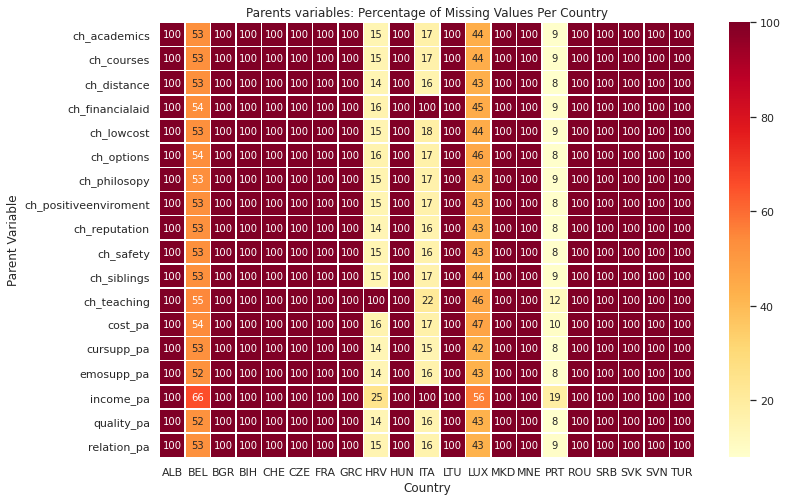

In [163]:
graph_parents, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(missing_df, cmap='YlOrRd', linewidths=0.5, annot=True, annot_kws={"size": 10}, fmt=".0f", ax=ax)

ax.set_title('Parents variables: Percentage of Missing Values Per Country')
ax.set_xlabel('Country')
ax.set_ylabel('Parent Variable')

# Set the background color to white
ax.set_facecolor('white')

# Save the figure
graph_parents.savefig('PA_missing.png', dpi=300, bbox_inches='tight', facecolor='white')


In [164]:
#Loooking at remaining controls
variables = sorted([col for col in df.columns if col in potential_controls and col not in parents])

# Create a DataFrame to store the percentage of missing values
missing_df = pd.DataFrame(index=variables, columns=countries)

for country in countries:
    country_data = df[df['cnt'] == country]
    
    for var in variables:
        missing = country_data[var].isnull().sum()
        total = len(country_data[var])
        percent_missing = (missing / total) * 100

        # Populate the datafram with percentages
        missing_df.loc[var, country] = percent_missing  
        
# Enshure all vars are numeric
missing_df = missing_df.apply(pd.to_numeric, errors='coerce')

# Convert column names to strings
missing_df.columns = missing_df.columns.astype(str)
missing_df = missing_df.sort_index(axis=1)

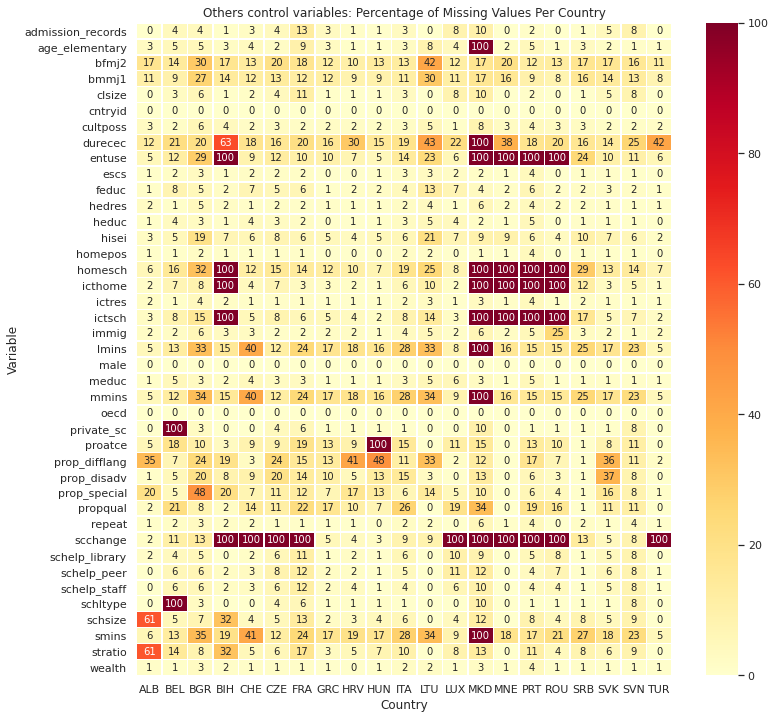

In [165]:
graph_covariates, ax = plt.subplots(figsize=(12, 12))

# Create the heatmap on the axes 'ax'
sns.heatmap(missing_df, cmap='YlOrRd', linewidths=0.5, annot=True, annot_kws={"size": 10}, fmt=".0f", ax=ax)

ax.set_title('Others control variables: Percentage of Missing Values Per Country')
ax.set_xlabel('Country')
ax.set_ylabel('Variable')

# Set the background color to white
ax.set_facecolor('white')

# Save the figure
graph_covariates.savefig('CONT_missing.png', dpi=300, bbox_inches='tight', facecolor='white')

#### Dropping (B)
As it clearly appears from the above graphs the percentage of missing values per country for the parents variable is huge.
The reason for this is that not all countries are shown the parent questionnairre in each PISA wave.

Given that only three countries display a reasonnable amount of missing values, namely Croatia, Italy and Portugal I will exclude completely parent variables from covariates set ment to be used with all countries.

Coming to student and school related covariates we can notice how some variables result missing for many countries, namely:
- 'entuse'
- 'homesch'
- 'icthome'
- 'ictsch'
- 'scchange'

I will thus remove those variables, which I do not deem so central to my analysis.

Further, other countries present 100% missing values in other variables:
- Country: Hungary, var:'proatce' 
- Country: North Macedonia, vars: 'smins', 'lmins', 'smins' and 'age_elementary'

In [166]:
#Drop the useless excess missing variables 
droplistB = ['entuse','homesch','icthome','ictsch','scchange']

In [167]:
df.drop(droplistB, axis=1, inplace =True) 

### C) Aggregation Levels datasets 
I will generate the three datasets and ispect them in terms of number of observations, number of countries and correlation matrix

In [168]:
# GENERATE THE THREE DATASETS 
maxdrop = ['homepos', 'hisei', 'meduc', 'feduc', 'heduc', 'bmmj1','bfmj2']
moderatedrop = ['escs', 'meduc', 'feduc', 'bmmj1','bfmj2']
mindrop= ['escs', 'heduc', 'hisei']
df_MaxAggreg = df.drop(maxdrop, axis=1)
df_Aggreg = df.drop(moderatedrop, axis=1) #keep homepos and 1 of the parents variable (the highest) 
df_MinAggreg = df.drop(mindrop, axis=1) #keep both parents indexes

In [169]:
i=0
for df in [df_MaxAggreg, df_Aggreg, df_MinAggreg]:
    i=i+1
    X_to_test = sorted([col for col in df.columns if col not in parents and col not in not_controls])
 
    df_drop_i = df.dropna(subset=X_to_test)

    print(df_drop_i.shape)

(36005, 163)
(34773, 165)
(29854, 167)


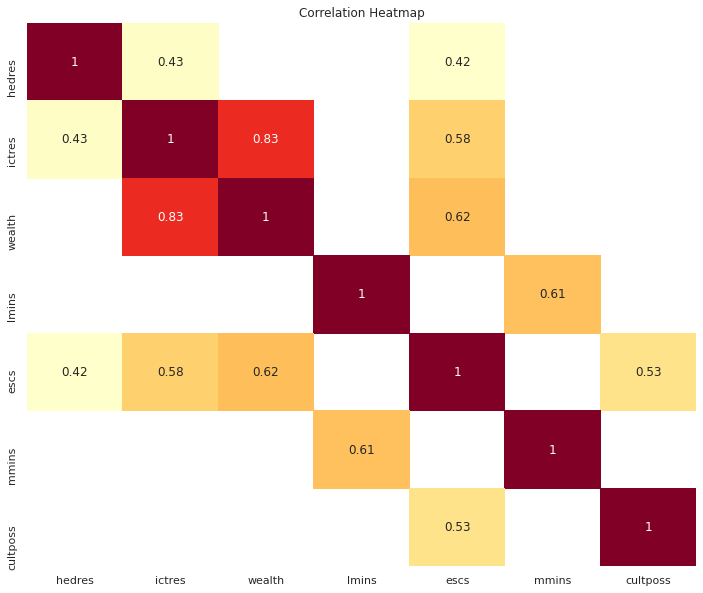

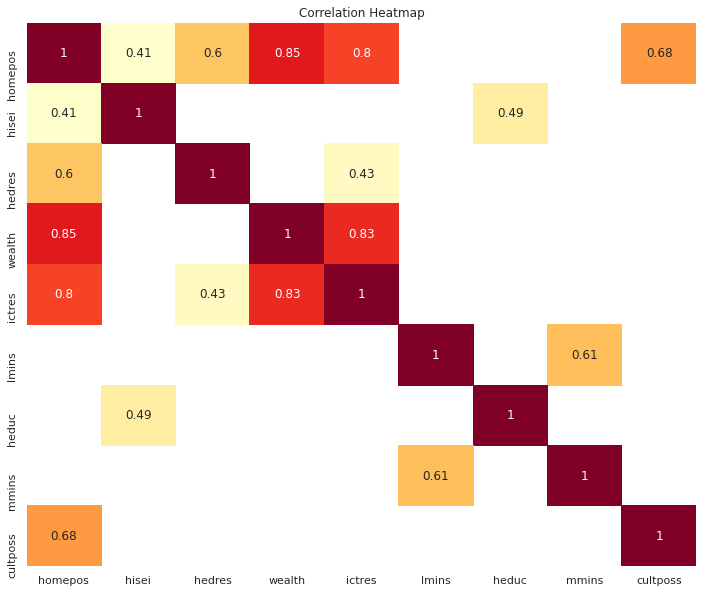

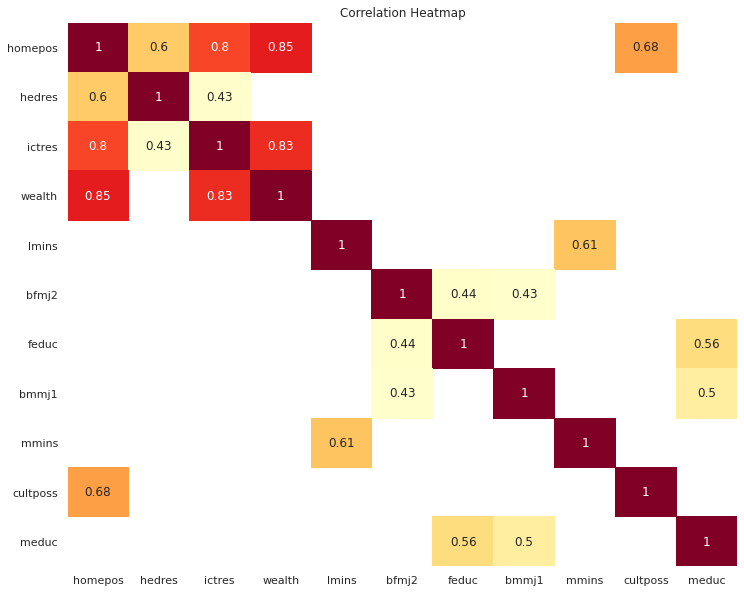

In [170]:
for df in [df_MaxAggreg, df_Aggreg, df_MinAggreg]:
    X = [col for col in df if col not in parents and col not in not_controls]
    
    a = CorrelationTreshold(df[X], 0.4)
    
    #graph
    corr_matrix = df[a].corr()
    mask = corr_matrix < 0.4
    # Plot the heatmap
    
    sns.set(style='white')
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='YlOrRd', mask=mask, cbar=False)
    plt.title('Correlation Heatmap')
    plt.show()

In [171]:
df = df_Aggreg.copy(deep=True)

I decide to keep the medium aggregate dataset as it allows for some more interesting variables to comment on  at the price of few observations 

# Covariates Selection

E) Analyze the relevance of variables:
I will first divide controls in student and school controls and select the most relevant variables in the two subgroups. Relevance is assessed by means of:
- Shapely values 
    - Mean shapely = average contribution of variable across all dataset permutation
    - Max shapely = max registered contribution of variable over all permutation 
- Permutation feature importance  

D) Analyze number of observations and distribution of missing values to understand which are mort worth of being dropped (higher gain in observations)


In [172]:
# Covariates subgrouping
Covariates = sorted([col for col in df.columns if col not in parents and col not in not_controls])
print(Covariates)

['admission_records', 'age_elementary', 'clsize', 'cntryid', 'cultposs', 'durecec', 'hedres', 'heduc', 'hisei', 'homepos', 'ictres', 'immig', 'lmins', 'male', 'mmins', 'oecd', 'private_sc', 'proatce', 'prop_difflang', 'prop_disadv', 'prop_special', 'propqual', 'repeat', 'schelp_library', 'schelp_peer', 'schelp_staff', 'schltype', 'schsize', 'smins', 'stratio', 'wealth']


In [173]:
school = ['admission_records', 'clsize', 'lmins', 
          'mmins', 'private_sc', 'proatce', 'prop_difflang', 'prop_disadv', 
          'prop_special', 'propqual', 'schelp_library', 'schelp_peer', 'schelp_staff', 
          'schltype', 'schsize', 'smins', 'stratio']
student = ['age_elementary', 'cultposs', 'durecec', 'hedres', 'heduc', 'hisei', 'homepos', 
           'ictres', 'immig', 'male', 'repeat', 'wealth']

CONTROLS SUBSET =  ['admission_records', 'clsize', 'lmins', 'mmins', 'private_sc', 'proatce', 'prop_difflang', 'prop_disadv', 'prop_special', 'propqual', 'schelp_library', 'schelp_peer', 'schelp_staff', 'schltype', 'schsize', 'smins', 'stratio']


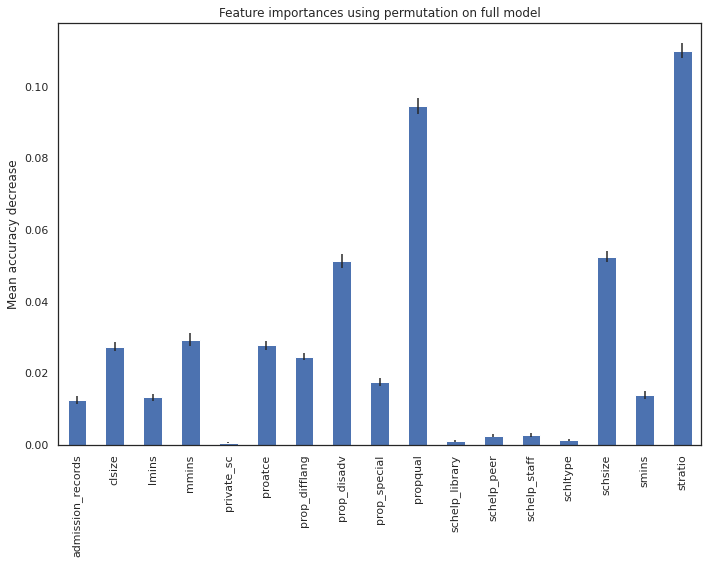

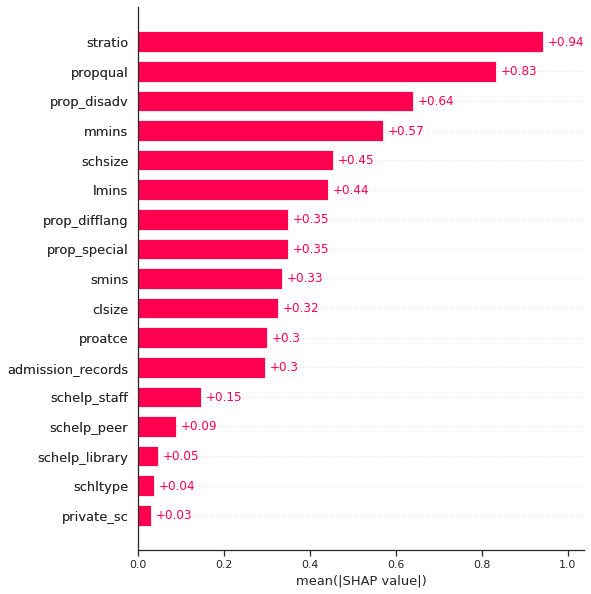

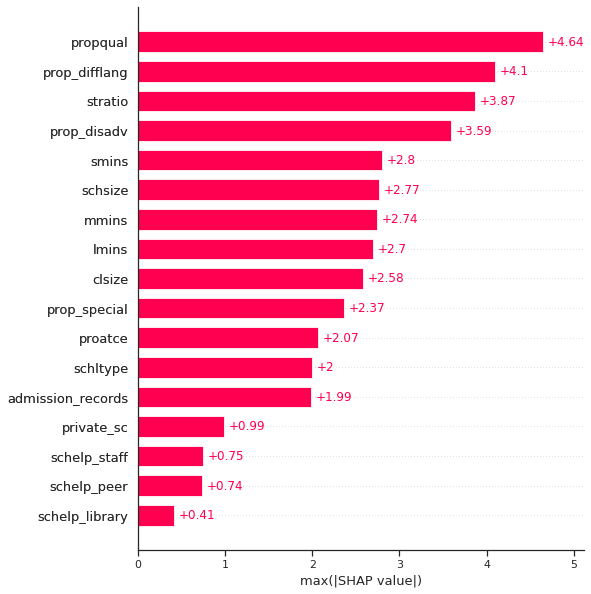

CONTROLS SUBSET =  ['age_elementary', 'cultposs', 'durecec', 'hedres', 'heduc', 'hisei', 'homepos', 'ictres', 'immig', 'male', 'repeat', 'wealth']


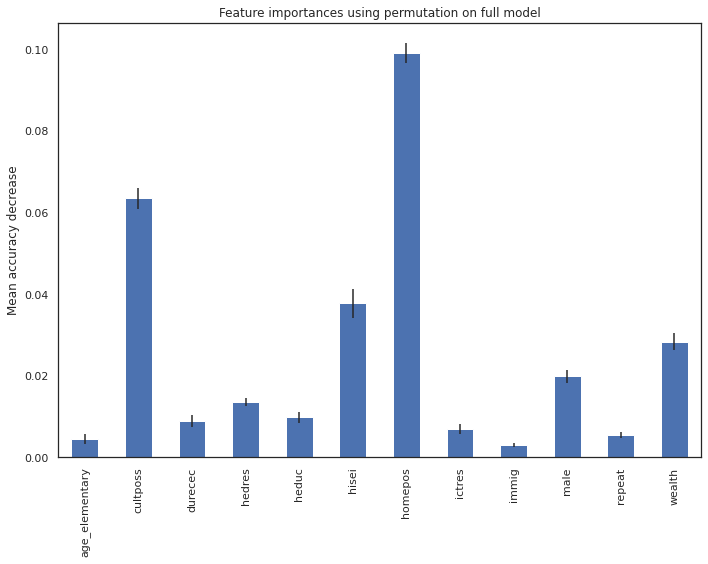

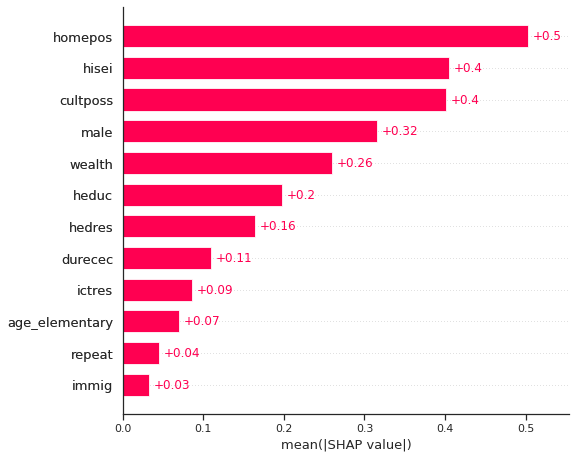

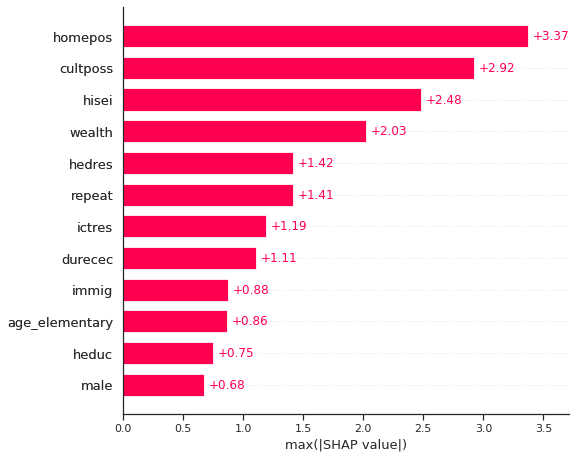

In [174]:
#2)SHAPELY VALUES AND PERMUTATION IMPORTANCE FOR ALL DATASETS

for lists in [school, student]:

    X_to_test = sorted(lists)
    
    print('CONTROLS SUBSET = ', lists)
    df_dropped = df.dropna(subset=X_to_test)

    X_train, X_test, y_train, y_test = train_test_split(df_dropped[X_to_test], df_dropped['g'], 
                                                        shuffle=True, stratify=df_dropped['g'], 
                                                        random_state=state, test_size=0.2)

    test = XGBClassifier(random_state=state)

    fitted = test.fit(X_train, y_train)

    #PERMUTATION IMPORTANCE
    result =permutation_importance(fitted, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

    importances = pd.Series(result.importances_mean, index=df_dropped[X_to_test].columns.tolist())

    fig, ax = plt.subplots(figsize=(10,8))
    importances.plot.bar(yerr=result.importances_std, ax=ax)
    ax.set_title("Feature importances using permutation on full model")
    ax.set_ylabel("Mean accuracy decrease")
    fig.tight_layout()
    plt.show()

    ############################################

    #SHAPELY VALUES
    explainer = shap.Explainer(fitted)
    shap_values = explainer(df_dropped[X_to_test])

    #MEAN SHAP VALUES
    shap.plots.bar(shap_values, max_display=len(X_to_test))
    
    #MAX SHAP VALUE
    shap.plots.bar(shap_values.abs.max(0), max_display=len(X_to_test))
    


In [175]:
important_vars = ['stratio', 'schsize', 'propqual', 'prop_disadv', 
                  'immig', 'cntryid', 'oecd', 'male', 'hisei', 'heduc', 'homepos'] 
                #vars important either for interpretation or bc explain a lot
useless_vars = [col for col in df.columns if col.startswith('schelp')] + ['schltype'] + ['private_sc']
print(useless_vars)

['schelp_staff', 'schelp_library', 'schelp_peer', 'schltype', 'private_sc']


In [176]:
df.drop(useless_vars, axis=1, inplace=True)

In [177]:
evaluate = sorted([col for col in df.columns if 
                     col not in parents and col not in not_controls and col not in important_vars])

MissingEvaluate(df[evaluate], 200)
 


    MISSING VALS AND UNIQUE MISSING
    
admission_records has 3749 missing values and 342 unique missing values
cultposs has 3260 missing values and 275 unique missing values
durecec has 31357 missing values and 13559 unique missing values
proatce has 15307 missing values and 4856 unique missing values
prop_difflang has 17140 missing values and 4335 unique missing values
prop_special has 11436 missing values and 2030 unique missing values
smins has 27437 missing values and 686 unique missing values

    COMMON MISSING
    
age_elementary durecec have 713 observation(s) with common missing values
age_elementary cultposs durecec hedres ictres lmins mmins repeat smins wealth have 888 observation(s) with common missing values
age_elementary durecec lmins mmins smins have 4270 observation(s) with common missing values
durecec prop_difflang have 1187 observation(s) with common missing values
lmins mmins prop_difflang smins have 794 observation(s) with common missing values
lmins mmins smin

# Choice

Based on the above I decide to drop durecec prop_diff prop special all the variables regarding minutes and proatce

In [178]:
#Creation of the final dataset
df = pd.read_csv("DatasetPreSelection.csv") 
df_final = df_untouch.copy(deep=True)
finaldroplist = ( ['Unnamed: 0', 'entuse','homesch','icthome','ictsch','scchange'] 
                 + ['escs', 'meduc', 'feduc', 'bmmj1','bfmj2']
                 + ['schelp_library', 'schelp_staff', 'schelp_peer']
                 + ['schltype', 'private_sc','durecec', 'prop_difflang', 'prop_special', 
                    'proatce', 'admission_records'])
                 

In [179]:
df.drop(finaldroplist, axis=1, inplace=True)

covariates = sorted([col for col in df.columns if col not in parents and col not in not_controls])

df.dropna(subset=covariates, inplace=True)

In [180]:
print(f'Final dataset dimensions (obs,n°vars) = {df.shape}, of which variables {len(df[covariates].columns.tolist())} are covariates')
print(f'Covariates set = {df[covariates].columns.tolist()}')
print('Included countries', df['cnt'].unique())

Final dataset dimensions (obs,n°vars) = (61000, 155), of which variables 21 are covariates
Covariates set = ['age_elementary', 'clsize', 'cntryid', 'cultposs', 'hedres', 'heduc', 'hisei', 'homepos', 'ictres', 'immig', 'lmins', 'male', 'mmins', 'oecd', 'prop_disadv', 'propqual', 'repeat', 'schsize', 'smins', 'stratio', 'wealth']
Included countries ['ALB' 'BEL' 'BGR' 'BIH' 'CHE' 'CZE' 'FRA' 'GRC' 'HRV' 'HUN' 'ITA' 'LTU'
 'LUX' 'MNE' 'PRT' 'ROU' 'SRB' 'SVK' 'SVN' 'TUR']


In [181]:
df.to_csv('Cleaned_2018.csv')

In [182]:
import pandas as pd
df = pd.read_csv('Cleaned_2018.csv')

df.drop('Unnamed: 0', axis=1, inplace=True)

parents = [col for col in df.columns if col.endswith('_pa') or col.startswith('ch_')]
pvs = [col for col in df.columns if col.startswith('pv')]
weights = [col for col in df.columns if col.startswith('w_')]
not_controls  = ['g', 'cnt', 'cntschid', 'cntstuid', 'progn']  + pvs + weights

covariates = sorted([col for col in df.columns if col not in parents and col not in not_controls])

In [183]:
print(covariates)
stats = covariates
stats.remove('cntryid')
stats.remove('oecd')
print(stats)

['age_elementary', 'clsize', 'cntryid', 'cultposs', 'hedres', 'heduc', 'hisei', 'homepos', 'ictres', 'immig', 'lmins', 'male', 'mmins', 'oecd', 'prop_disadv', 'propqual', 'repeat', 'schsize', 'smins', 'stratio', 'wealth']
['age_elementary', 'clsize', 'cultposs', 'hedres', 'heduc', 'hisei', 'homepos', 'ictres', 'immig', 'lmins', 'male', 'mmins', 'prop_disadv', 'propqual', 'repeat', 'schsize', 'smins', 'stratio', 'wealth']


In [184]:
df_treated = df[df['g'] == 1]
df_control = df[df['g'] == 0]

stats_treat = {}
stats_control = {}

# Calculate weighted statistics for treatment group
for var in stats:  # Replace with your actual covariates
    wdf = DescrStatsW(df_treated[var], weights=df_treated['w_fstuwt'], ddof=1)
    quantiles = wdf.quantile([0.25, 0.50, 0.75])

    stats_treat[var] = {
        'Weighted Mean': wdf.mean,
        'Weighted Std': wdf.std,
        'Min': df_treated[var].min(),
        'Weighted 25%': quantiles.loc[0.25].item(),
        'Weighted 50%': quantiles.loc[0.50].item(),
        'Weighted 75%': quantiles.loc[0.75].item(),
        'Max': df_treated[var].max()
    }

# Calculate weighted statistics for control group
for var in stats:  # Replace with your actual covariates
    wdf = DescrStatsW(df_control[var], weights=df_control['w_fstuwt'], ddof=1)  # Use df_control weights
    quantiles = wdf.quantile([0.25, 0.50, 0.75])

    stats_control[var] = {
        'Weighted Mean': wdf.mean,
        'Weighted Std': wdf.std,
        'Min': df_control[var].min(),
        'Weighted 25%': quantiles.loc[0.25].item(),
        'Weighted 50%': quantiles.loc[0.50].item(),
        'Weighted 75%': quantiles.loc[0.75].item(),
        'Max': df_control[var].max()
    }

# Create DataFrames for treatment and control groups
result_treat = pd.DataFrame(stats_treat)
result_control = pd.DataFrame(stats_control)

# Print the resulting DataFrames
print('TREATMENT GROUP')
display(result_treat)

print('CONTROL GROUP')
display(result_control)


TREATMENT GROUP


,age_elementary,clsize,cultposs,hedres,heduc,hisei,homepos,ictres,immig,lmins,male,mmins,prop_disadv,propqual,repeat,schsize,smins,stratio,wealth
Weighted Mean,5.370726,34.062702,-0.296002,-0.082403,13.216509,49.252498,-0.401596,-0.461544,1.070107,214.527027,0.451046,225.503939,20.657506,1.019566,0.039297,805.925496,204.805955,12.557559,-0.544759
Weighted Std,0.819986,11.417526,1.112971,0.978076,3.285433,23.666033,1.067712,0.996918,0.308469,81.445614,0.497598,83.890677,20.486138,0.443624,0.194302,506.323303,121.923175,4.066600,1.056449
Min,3.000000,13.000000,-2.746900,-4.491100,0.000000,11.560000,-6.679500,-3.967700,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,1.000000,-6.846000
Weighted 25%,5.000000,28.000000,-1.033800,-0.685300,12.000000,27.910000,-1.024100,-0.940000,1.000000,180.000000,0.000000,180.000000,4.000000,0.981800,0.000000,452.000000,120.000000,10.549000,-1.216900
Weighted 50%,5.000000,33.000000,-0.259600,-0.135700,14.500000,51.500000,-0.318000,-0.362900,1.000000,200.000000,0.000000,240.000000,15.000000,1.019700,0.000000,712.000000,200.000000,12.644400,-0.457700
Weighted 75%,6.000000,38.000000,0.445500,1.179300,16.000000,71.390000,0.308400,0.104200,1.000000,240.000000,1.000000,240.000000,30.000000,1.178600,0.000000,1046.000000,280.000000,14.708300,0.165800
Max,8.000000,53.000000,2.076000,1.209900,16.000000,88.960000,5.760800,3.612000,3.000000,2100.000000,1.000000,2160.000000,100.000000,3.000000,1.000000,8150.000000,2160.000000,100.000000,4.504600


CONTROL GROUP


,age_elementary,clsize,cultposs,hedres,heduc,hisei,homepos,ictres,immig,lmins,male,mmins,prop_disadv,propqual,repeat,schsize,smins,stratio,wealth
Weighted Mean,5.434885,31.761055,-0.604043,-0.263572,12.070095,37.620035,-0.767398,-0.684773,1.076067,211.307543,0.574781,202.467128,30.431877,0.984987,0.104181,795.759122,157.289047,10.814767,-0.769588
Weighted Std,0.836099,12.932812,1.015200,1.040592,3.238224,19.684004,0.995258,0.965899,0.331725,107.138859,0.494377,99.763943,25.542492,0.348682,0.305496,556.558910,132.405859,4.649608,1.034609
Min,3.000000,13.000000,-2.746900,-4.491100,0.000000,11.010000,-9.113700,-3.814500,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,1.000000,-7.546500
Weighted 25%,5.000000,23.000000,-1.268700,-1.011800,9.000000,23.470000,-1.371700,-1.227500,1.000000,160.000000,0.000000,135.000000,10.000000,0.920200,0.000000,418.000000,80.000000,8.260900,-1.426300
Weighted 50%,5.000000,28.000000,-0.554400,-0.135700,12.000000,30.340000,-0.696000,-0.623100,1.000000,200.000000,1.000000,200.000000,23.000000,1.000000,0.000000,695.000000,120.000000,10.250000,-0.713400
Weighted 75%,6.000000,38.000000,0.077900,0.760400,14.500000,51.560000,-0.118300,-0.133000,1.000000,240.000000,1.000000,240.000000,50.000000,1.101700,0.000000,1012.000000,240.000000,12.634600,-0.066900
Max,8.000000,53.000000,2.125000,1.209900,16.000000,88.960000,5.137800,3.605000,3.000000,2400.000000,1.000000,2400.000000,100.000000,2.149300,1.000000,8150.000000,2400.000000,100.000000,4.482100
